In [7]:
# required packages
import pandas as pd
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the data
data = pd.read_csv('/Users/enamul/Desktop/Programming/Data/online_retail_clean_data.csv')

# Display the first 5 rows of the dataframe
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
# Convert InvoiceDate from object to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate Recency, Frequency and Monetary value for each customer
snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1) #latest date in the data set plus one day
customers = data.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'Price': 'sum'})

# Rename the columns 
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'Invoice': 'Frequency',
                            'Price': 'MonetaryValue'}, inplace=True)

# Display the first 5 rows
customers.head()

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346.0,67,45,565.42
12347.0,3,71,162.95
12348.0,74,20,14.39
12349.0,43,107,899.49
12351.0,11,21,49.46


/opt/homebrew/anaconda3/envs/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

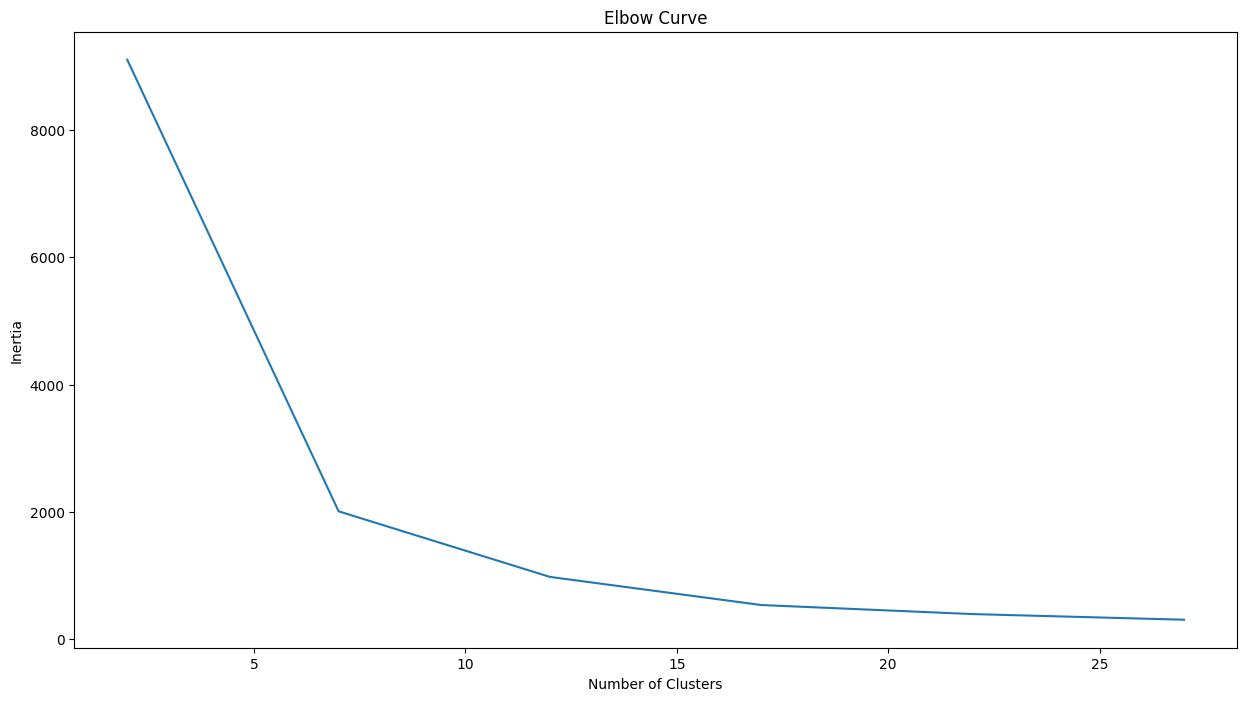

In [8]:
# Initialize the Object
scaler = StandardScaler()

# Fit and Transform The Data
scaler.fit(customers)
customers_normalized = scaler.transform(customers)

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the inertia for every k value
possible_k_values = range(2, 30, 5)

# Calculate inertia for the range of k values
inertia = []
for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(customers_normalized)
    inertia.append(kmeans.inertia_)

# Create the Elbow Curve using matplotlib and seaborn
plt.figure(figsize=(15,8))
sns.lineplot(x=possible_k_values, y=inertia)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
# Create a KMeans object with the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=1) 

# Fit the KMeans object with the normalized data
kmeans.fit(customers_normalized)

# Create a new column in the customers dataframe with the cluster each customer belongs to
customers['Cluster'] = kmeans.labels_

# Show the first few rows of the customers dataframe
customers.head()

/opt/homebrew/anaconda3/envs/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Recency,Frequency,MonetaryValue,Cluster
Customer ID,,,,
12346.0,67,45,565.42,0
12347.0,3,71,162.95,0
12348.0,74,20,14.39,0
12349.0,43,107,899.49,0
12351.0,11,21,49.46,0


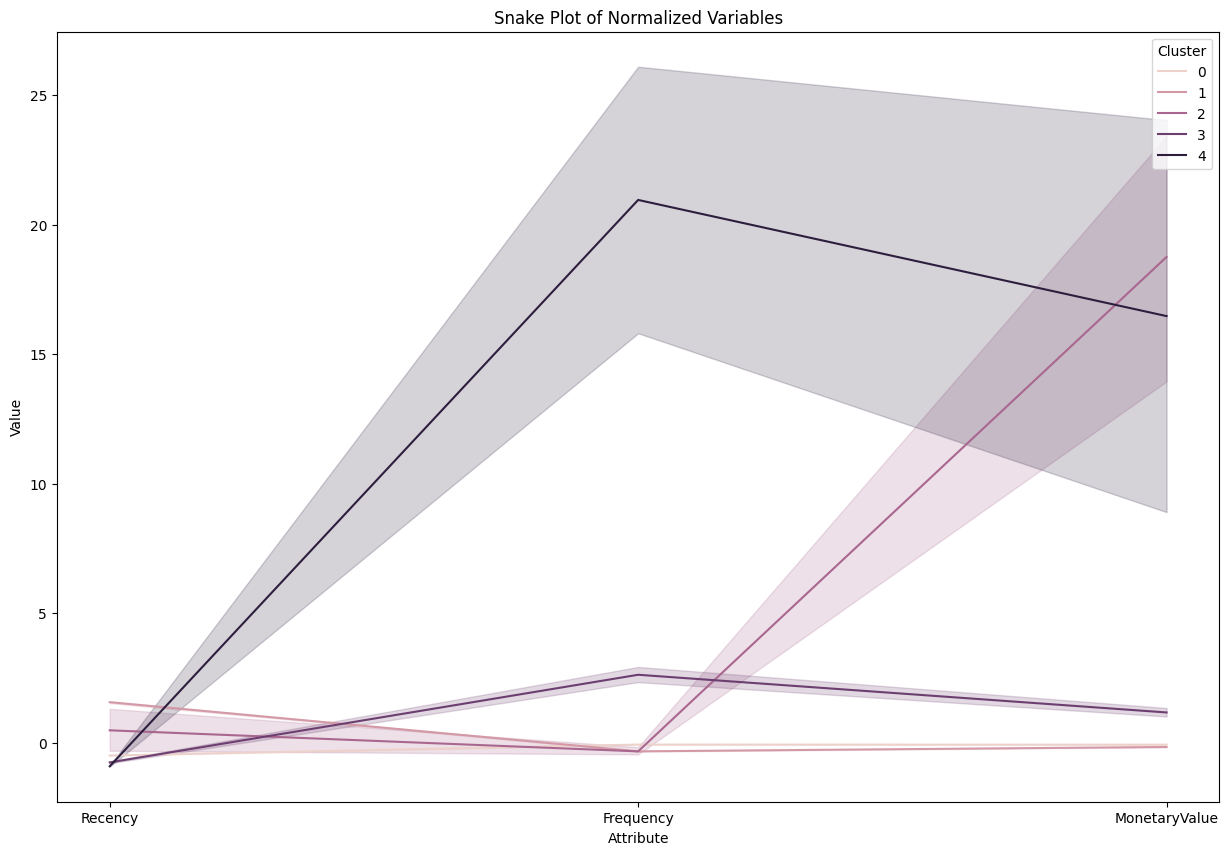

In [11]:
# Add cluster column to the normalized dataframe
customers_normalized = pd.DataFrame(customers_normalized, columns=["Recency", "Frequency", "MonetaryValue"], index=customers.index)
customers_normalized['Cluster'] = kmeans.labels_

# Melt The Data
df_nor_melt = pd.melt(customers_normalized.reset_index(), 
                    id_vars=['Customer ID', 'Cluster'],
                    value_vars=['Recency','Frequency','MonetaryValue'], 
                    var_name='Attribute', 
                    value_name='Value')

# Visualize it
plt.figure(figsize=(15,10))
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt)
plt.title('Snake Plot of Normalized Variables')
plt.xlabel('Attribute')
plt.ylabel('Value')
plt.show()

In [12]:
# Calculate average RFM values and size for each cluster
cluster_summary = customers.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

# Print the summary table
print(cluster_summary)

        Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          43.3      80.5         265.1  3130
1         245.2      27.8         137.0  1062
2         138.8      27.5       27446.7     6
3          17.3     624.3        2061.3   179
4           2.8    4323.2       24149.8     4


Cluster 0 (3130 customers): These customers have a low recency (43.3), high frequency (80.5), and high monetary value (265.1), which suggests that they are regular and loyal customers. They've made a purchase quite recently, they make purchases frequently, and they tend to spend a decent amount of money. These customers are very valuable, and it would be beneficial to keep them engaged with loyalty programs, personalized offers, and excellent customer service.

Cluster 1 (1062 customers): These customers have high recency (245.2), low frequency (27.8), and low monetary value (137.0). These customers haven't made a purchase in quite a while, and when they did, they didn't make purchases often and didn't spend a lot. They could be customers who have stopped shopping. It might be worth reaching out to these customers with re-engagement campaigns or surveys to discover why they stopped shopping.

Cluster 2 (6 customers): These customers have a moderate recency (138.8), low frequency (27.5), and very high monetary value (27446.7). This small group of customers don't make purchases often, but when they do, they spend a lot of money. These could be bulk buyers or wholesale customers. It might be beneficial to reach out to these customers and build strong relationships with personalized service, as they could contribute significantly to the revenue due to their high spend.

Cluster 3 (179 customers): These customers have very low recency (17.3), high frequency (624.3), and high monetary value (2061.3). These are very active customers who make purchases frequently and spend a lot. They have made purchases very recently. These are high-value customers that should be retained. They could be targeted with loyalty programs and personalized marketing.

Cluster 4 (4 customers): These customers have extremely low recency (2.8), very high frequency (4323.2), and very high monetary value (24149.8). These customers make purchases extremely frequently and spend a lot of money. They have made purchases very recently. This is a very small but extremely valuable group of customers. Given their high frequency and spend, they could be corporate customers or super consumers. It would be worth building strong relationships with these customers and providing them with exceptional service.

In [14]:
import joblib

# Save the model
joblib.dump(kmeans, '/Users/enamul/Desktop/Data Science Projects/Customer Segmentation/model/cs_model.pkl')

['/Users/enamul/Desktop/Data Science Projects/Customer Segmentation/model/cs_model.pkl']